In [1]:
import astropy
import astropy.units as u
import lumos
import lumos.brdf
import lumos.brdf.library as brdf_library
import lumos.brdf.tools
import lumos.calculator
import lumos.conversions
import lumos.functions
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import EarthLocation
from lumos.brdf.library import BINOMIAL, LAMBERTIAN, PHONG
from lumos.geometry import Surface

from analysis import calculator, streakfunctions
from gen2_starlink import satellitemodels

from skyfield.api import Distance
from skyfield.toposlib import ITRSPosition
from skyfield.api import Topos, load
from datetime import datetime
from tqdm import tqdm

from skyfield.api import load, wgs84

In [2]:
obs_in_field = pd.read_csv('../data/Observations_in_field.csv')


obs_in_field

,sun altitude,sat altitude,sat height,measured_ab,irradiance,aoi,az diff
0,-26.0,28.0,526911.5,6.853554,4.970910e-11,19.4,22.1
1,-26.0,27.9,526914.7,6.866349,4.912670e-11,19.3,21.2
2,-26.0,27.8,526917.9,6.835958,5.052130e-11,19.2,20.5
3,-26.0,27.7,526921.6,6.877742,4.861390e-11,19.2,19.5
4,-26.0,27.6,526924.3,6.836369,5.050220e-11,19.1,18.8
...,...,...,...,...,...,...,...
1579,-24.2,38.6,532422.1,6.628437,6.116220e-11,19.6,31.4
1580,-24.2,40.5,532365.9,6.536421,6.657170e-11,19.9,30.6
1581,-15.9,22.0,527267.8,5.797010,1.315389e-10,7.3,15.6
1582,-15.9,20.5,527274.1,5.259296,2.158439e-10,6.6,11.4


In [48]:
#obs_in_field.to_csv('../data/Observations_in_field.csv', index=False)

In [3]:
# Setting up the satellite model surfaces and earth_brdf.
surfaces = satellitemodels.get_surfaces()
earth_brdf = lumos.brdf.library.PHONG(Kd = 0.2, Ks = 0.2, n=300)

Using interpolated chassis


In [5]:
lowsats = obs_in_field.loc[obs_in_field["aoi"] <= 10].copy()
highsats = obs_in_field.loc[obs_in_field["aoi"] > 10].copy()

In [6]:
lowsats_intensities = calculator.get_intensity_observer_frame(
    surfaces,
    np.array(lowsats["sat height"]),
    np.array(lowsats["sat altitude"]),
    np.array(lowsats["az diff"]*0),
    np.array(lowsats["sun altitude"]),
    np.array(lowsats["az diff"]),
    include_sun=True,
    include_earthshine=True,
    earth_panel_density=151,
    earth_brdf=earth_brdf
)

lowsats_ab = lumos.conversions.intensity_to_ab_mag(lowsats_intensities)


# Calculating brightness of satellites with a large angle of incidence.
highsats_intensities = calculator.get_intensity_observer_frame(
    surfaces,
    np.array(highsats["sat height"]),
    np.array(highsats["sat altitude"]),
    np.array(highsats["az diff"]*0),
    np.array(highsats["sun altitude"]),
    np.array(highsats["az diff"]),
    include_sun=True,
    include_earthshine=False,
    earth_panel_density=151,
    earth_brdf=earth_brdf
)

highsats_ab = lumos.conversions.intensity_to_ab_mag(highsats_intensities)

In [7]:
lowsats["calculated ab"] = lowsats_ab
highsats["calculated ab"] = highsats_ab
mergesats = pd.concat([lowsats, highsats], ignore_index=True)
dfs = mergesats

In [8]:
error = dfs["measured_ab"] - dfs["calculated ab"]

Text(0, 0.5, '# Residuals')

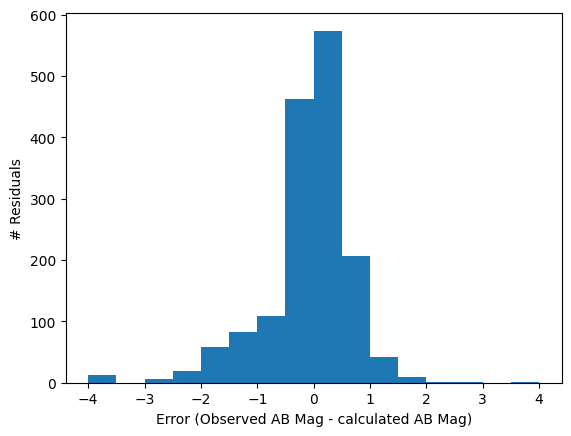

In [9]:
#plt.hist(error, bins=[-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.hist(error, bins=np.arange(-4,4.5,0.5))
plt.xlabel("Error (Observed AB Mag - calculated AB Mag)")
plt.ylabel("# Residuals")

Text(0.5, 1.0, 'Brightness Correlation')

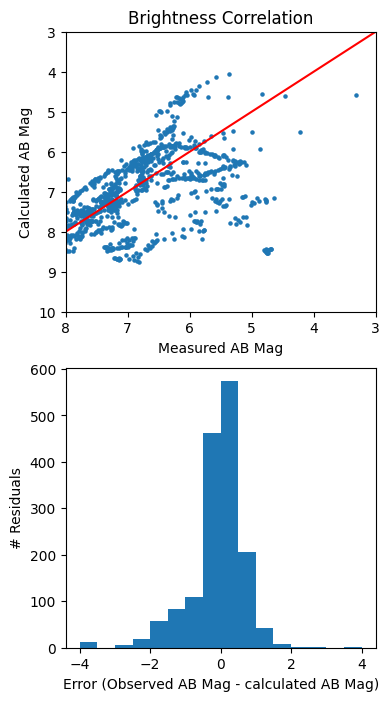

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))

ax2.hist(error, bins=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4])
ax2.set_xlabel("Error (Observed AB Mag - calculated AB Mag)")
ax2.set_ylabel("# Residuals")

ax1.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5)
ax1.plot([12, 3], [12, 3], 'r-')
ax1.set_xlabel('Measured AB Mag')
ax1.set_ylabel('Calculated AB Mag')
ax1.set_xlim(8,3)
ax1.set_ylim(10,3)
ax1.set_title("Brightness Correlation")

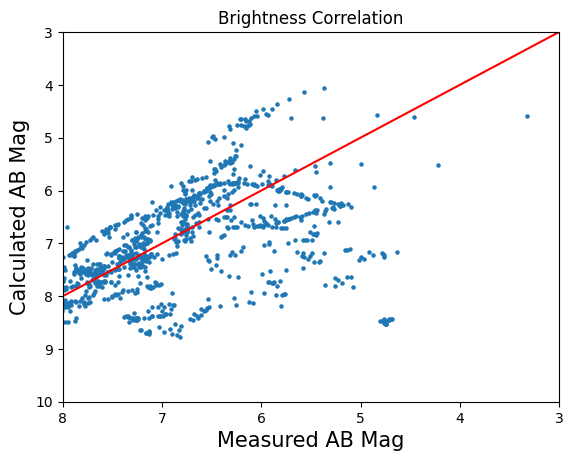

In [11]:
#plt.figure(figsize=(7,5))
plt.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5)
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(8,3)
plt.ylim(10,3)
plt.title("Brightness Correlation")
plt.show()

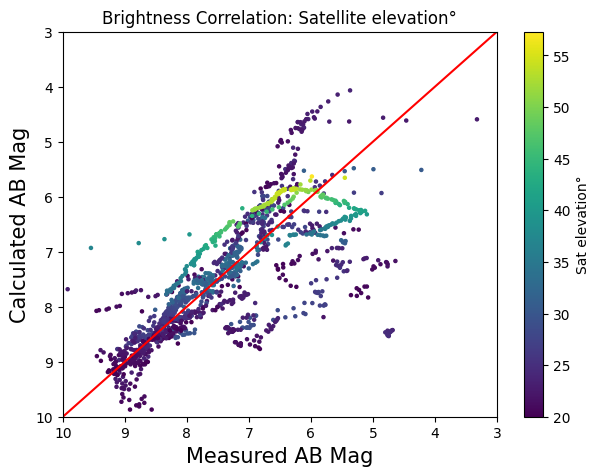

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5, c=dfs["sat altitude"], cmap="viridis")
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(10,3)
plt.ylim(10,3)
plt.title("Brightness Correlation: Satellite elevation°")
cbar = plt.colorbar()
cbar.set_label('Sat elevation°')
plt.show()

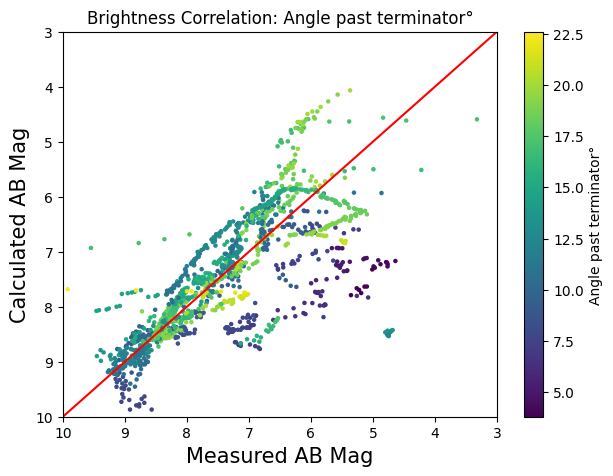

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5, c=dfs["aoi"], cmap="viridis")
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(10,3)
plt.ylim(10,3)
plt.title("Brightness Correlation: Angle past terminator°")
cbar = plt.colorbar()
cbar.set_label('Angle past terminator°')
plt.show()

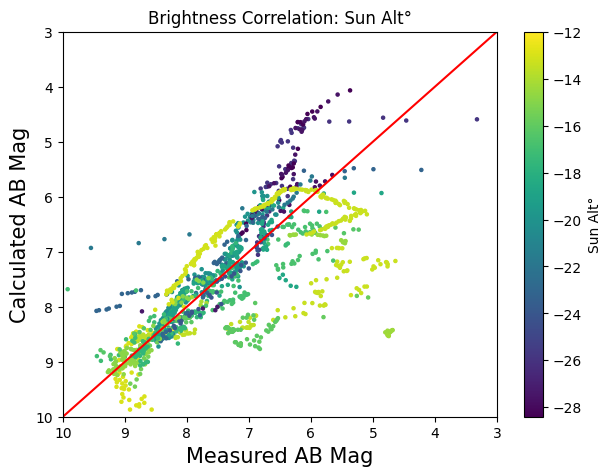

In [14]:
plt.figure(figsize=(7,5))
plt.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5, c=dfs["sun altitude"], cmap="viridis")
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(10,3)
plt.ylim(10,3)
plt.title("Brightness Correlation: Sun Alt°")
cbar = plt.colorbar()
cbar.set_label('Sun Alt°')
plt.show()

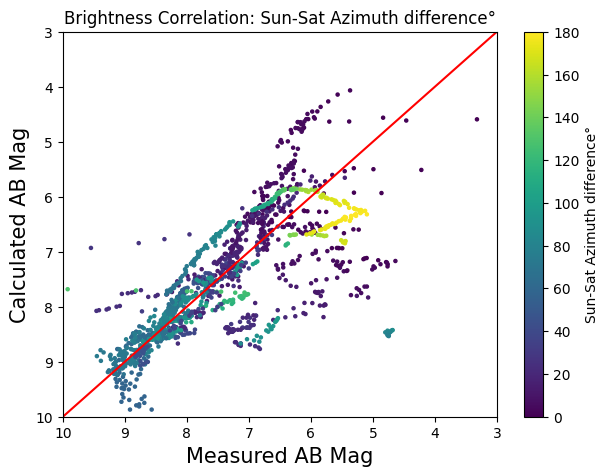

In [16]:
plt.figure(figsize=(7,5))
plt.scatter(dfs["measured_ab"],  dfs["calculated ab"], s=5, c=dfs["az diff"], cmap="viridis")
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(10,3)
plt.ylim(10,3)
plt.title("Brightness Correlation: Sun-Sat Azimuth difference°")
cbar = plt.colorbar()
cbar.set_label('Sun-Sat Azimuth difference°')
plt.show()